In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../qbiome'))

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
plt.style.use('ggplot')

from data_formatter import DataFormatter
from quantizer import Quantizer
from qnet_orchestrator import QnetOrchestrator
from forecaster import Forecaster

In [2]:
dirname = '../../infbiome_/data2/'
data = dirname + 'SamplesByMetadata_otuDADA2_EMP_10249_ECAM_RSRC_TaxaRelativeAbundance.csv'
meta = dirname + 'SamplesByMetadata_otuDADA2_EMP_10249_ECAM_RSRC_Characteristics.csv'

In [3]:
formatter = DataFormatter()
quantizer = Quantizer()
qnet_orchestrator = QnetOrchestrator(quantizer)
forecaster = Forecaster(qnet_orchestrator)

In [4]:
data = formatter.load_data(data, meta)
quantized = quantizer.quantize_df(data)
features, label_matrix = quantizer.get_qnet_inputs(quantized)

There are 29 unique biomes and 1216 unique samples
There are 311 unique days
There are 99 unique weeks


In [5]:
data.week.max(), len(features)

(98, 622)

In [6]:
qnet_orchestrator.load_qnet('biome_net.joblib')

In [7]:
# takes 10 minutes to run
forecasted = forecaster.forecast_data(label_matrix, start_week=10, 
                                   end_week=data.week.max())

In [8]:
data.head()

,sample_id,subject_id,variable,week,value
7,MBSMPL0020-6-10,1,Actinobacteriota,27,0.366650
8,MBSMPL0020-6-10,1,Bacteroidota,27,0.507248
9,MBSMPL0020-6-10,1,Campilobacterota,27,0.002032
10,MBSMPL0020-6-10,1,Desulfobacterota,27,0.005058
11,MBSMPL0020-6-10,1,Firmicutes,27,0.057767


In [9]:
forecasted.head()

,subject_id,variable,week,value
0,1,Acidobacteriota,1,NaN
1,10,Acidobacteriota,1,NaN
2,11,Acidobacteriota,1,NaN
3,12,Acidobacteriota,1,NaN
4,14,Acidobacteriota,1,NaN


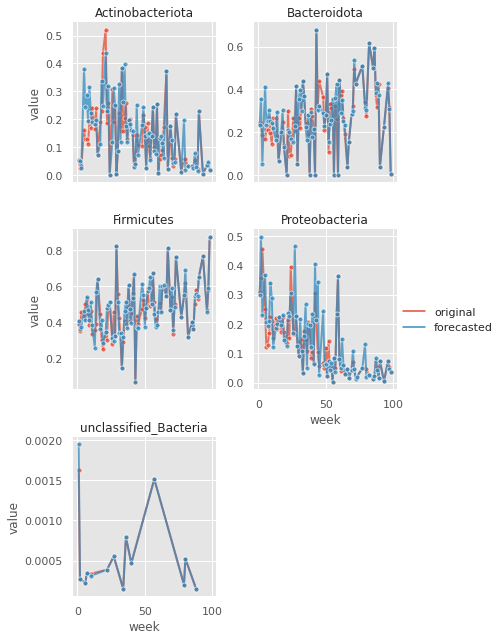

In [10]:
BIOMES = ['Actinobacteriota', 'Bacteroidota', 'Firmicutes', 'Proteobacteria', 'unclassified_Bacteria']

concat = pd.concat([
    data.assign(source='original'), 
    forecasted.assign(source='forecasted')
])
concat = concat[concat.variable.isin(BIOMES)]

g = sns.FacetGrid(concat, col='variable', col_wrap=2, sharey=False, margin_titles=True)
g.map_dataframe(sns.lineplot, 'week', 'value', hue='source', ci=None, marker='o',
                    linewidth=2, alpha=0.75, markersize=5)
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g.add_legend()

The forecast aligns pretty well with the original data.

Next we zoom in to look at the first 20 weeks. Note that there is still some conversion distortion due to quantization-dequantization.

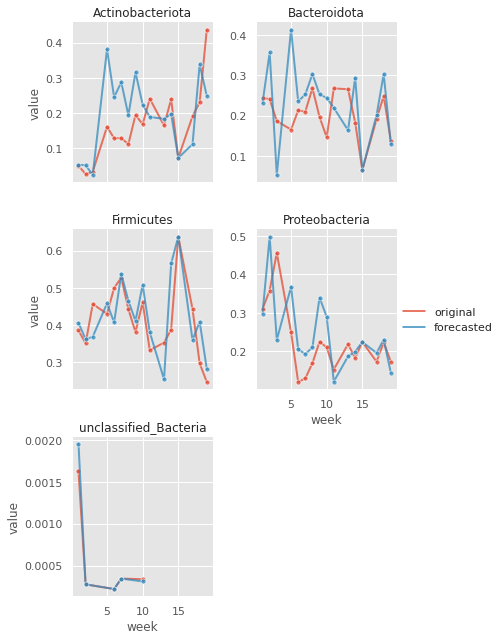

In [11]:
concat = concat[(concat.week <= 20)]

g = sns.FacetGrid(concat, col='variable', col_wrap=2, sharey=False, margin_titles=True)
g.map_dataframe(sns.lineplot, 'week', 'value', hue='source', ci=None, marker='o',
                    linewidth=2, alpha=0.75, markersize=5)
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g.add_legend()